# Imports

In [104]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import subprocess
import os as os
import seaborn as sns
import seaborn.objects as so
from glob2 import glob
from datetime import datetime
import pytz
from tqdm import tqdm
import random

In [105]:
dcml_chordtype_map = {
    "M": "major",
    "m": "minor",
    "Mm7": "dominant-7th",
    "o": "diminished",
    "o7": "full-diminished",
    "mm7": "minor-7th",
    "%7": "half-diminished",
    "MM7": "major-7th",
    "+": "augmented",
    "mM7": "minor-major-7th",
    "+7": "augmented-7th",
}

----

## Loading the Results
Loads all json files from the given folders

In [106]:
def get_all_experiments(path):
    experiments = set()
    experiment_types = set()
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.json'):
                if file[6] == "-":
                    continue
                experiments.add(file.split(".")[0])
                try:
                    experiment_types.add(file.split(".")[0].split("_")[1])
                except:
                    print(file)
    return experiments, experiment_types

In [107]:
def get_experiments(experiment_name):
    cols = ['id', 'corpus', 'piece', 'algorithm', 'accuracy', 'likelihood', 'chordLabels', 'slices','runTime', 'reruns']
    df = pd.DataFrame(columns=cols) 
    lbls = pd.DataFrame(columns=["piece", "corpus", "labels"])
    
    path = "outputs"
    experiments, experiment_types = get_all_experiments(path)
    if experiment_name in experiment_types:
        print("Getting runs of {}".format(experiment_name))
    else:
        print("Can't find experiment {}".format(experiment_name))
        return 
    
    fails = [] 
    successes = 0
    lbl_list = []
    df_list = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if experiment_name in file:
                try:
                    if file[6] == "-":
                        #ignore old format
                        continue
                        
                    with open(os.path.join(root, file), 'r') as f:
                        data = json.loads(f.read())
                except:
                    fails.append(file)
                    continue
                
                successes += 1

                newLbls = pd.DataFrame([{"corpus":data['corpus'], "piece":data["piece"], "labels": data["groundTruth"]}])
                lbl_list.append(newLbls)

                newdf = pd.json_normalize(data, record_path = ['results'], 
                    meta = ['id','corpus', 'piece','algorithm'])
                df_list.append(newdf)
    df = pd.concat(df_list)
    lbls = pd.concat(lbl_list)
    
    df["experiment"] = df["id"].apply(lambda x: x.split("_")[1] if "_" in x else np.nan)
    df["id"] = pd.to_datetime(df["id"].apply(lambda x: x.split("_")[0] if "_" in x else np.nan))
    #df = df.dropna(subset=["experiment"])
    results = df.set_index(["id","corpus", "piece"])
    print ("Parsed {} runs succesfully, consisting of {} unique experiments with {} failed runs".format(successes, results.index.levels[0].nunique(), len(fails)))
    return (results,lbls.set_index(["corpus", "piece"]))

In [108]:
def get_specific_experiment(experiment, time):
    (results, groundTruth) = get_experiments(experiment)
    print("Viewing latest result: {}".format(time))
    return (results.loc[results.index.get_level_values(0) == time], groundTruth)

In [109]:
def get_latest_experiment(experiment):
    (results, groundTruth) = get_experiments(experiment)
    latest_timestamp = results.index.get_level_values(0).max()
    print("Viewing latest result: {}".format(latest_timestamp))
    return (results.loc[results.index.get_level_values(0) == latest_timestamp], groundTruth)
        

# Organising results
Let's look at all experiments that have been run

# Random walk all pieces
Let's look at all experiments that have been run

In [110]:
experiments, experiment_types = get_all_experiments("outputs")

In [111]:
experiment_types

{'allexps',
 'allexps-checkpoint',
 'allexpssmaller',
 'allexpssmaller-checkpoint',
 'dual-stochastic-res-500-400vs3-1-grieg128',
 'dual-stochastic-res-500-400vs3-1-grieg128-checkpoint',
 'dual-stochastic-res-params',
 'dual-stochastic-res-params-checkpoint',
 'dual-stochastic-res-params-grieg128',
 'newheuristics',
 'parseable'}

In [112]:
(pr,pg) = get_latest_experiment("parseable")

Getting runs of parseable
Parsed 211 runs succesfully, consisting of 2 unique experiments with 118 failed runs
Viewing latest result: 2023-04-26 07:56:36


In [114]:
parsed = pr.loc[pr.accuracy.notna()]

In [115]:
parsed

accuracy  \
id                  corpus          piece                     
2023-04-26 07:56:36 ABC             n15op132_04    0.115044   
                                    n15op132_04    0.132743   
                                    n01op18-1_03   0.605911   
                                    n01op18-1_03   0.605911   
                                    n05op18-5_02   0.485030   
...                                                     ...   
                    chopin_mazurkas BI168op68-4    0.287500   
                                    BI61-5op07-5   0.657895   
                                    BI61-5op07-5   0.763158   
                                    BI162-3op63-3  0.211382   
                                    BI162-3op63-3  0.195122   

                                                                                         chordLabels  \
id                  corpus          piece                                                              
2023-04-26 07:56:36 ABC             n15op132_04    [EM, AM, AM, G♯o, AM, EMm7, AM, AM, AM, AM, DM...   
                                    n15op132_04    [EM, AM, AM, G♯o, AM, EMm7, AM, AM, AM, AM, DM...   
                                    n01op18-1_03   [FM, FM, CM, CM, DM, Gm, Gm, DM, DM, EM, Am, A...   
                                    n01op18-1_03   [FM, FM, CM, CM, DM, Gm, Gm, DM, DM, EM, Am, A...   
                                    n05op18-5_02   [C♯M, EM, AM, AM, BM, AM, F♯M, DM, D♯M, BMm7, ...   
...                                                                                              ...   
                    chopin_mazurkas BI168op68-4    [Fm, BM, G%7, B♭M, Co, G♯M, F%7, Bo7, EMm7, GM...   
                                    BI61-5op07-5   [GM, GMm7, CM, GMm7, CM, GMm7, GMm7, CM, CM, C...   
                                    BI61-5op07-5   [GM, GMm7, CM, GMm7, CM, GMm7, GMm7, CM, CM, C...   
                                    BI162-3op63-3  [AM, C♯M, D♯Mm7, G♯Mm7, D♯Mm7, C♯M, G♯M, G♯Mm7...   
                                    BI162-3op63-3  [AM, C♯M, G♯M, G♯Mm7, D♯Mm7, C♯m, D♯Mm7, G♯Mm7...   

                                                   likelihood reRuns  \
id                  corpus          piece                              
2023-04-26 07:56:36 ABC             n15op132_04    -12.768442    NaN   
                                    n15op132_04    -12.750313    NaN   
                                    n01op18-1_03   -13.351378    NaN   
                                    n01op18-1_03   -13.254541    NaN   
                                    n05op18-5_02   -12.853984    NaN   
...                                                       ...    ...   
                    chopin_mazurkas BI168op68-4    -12.660421    NaN   
                                    BI61-5op07-5   -12.988939    NaN   
                                    BI61-5op07-5   -12.471900    NaN   
                                    BI162-3op63-3  -12.325421    NaN   
                                    BI162-3op63-3  -12.564073    NaN   

                                                     runTime  \
id                  corpus          piece                      
2023-04-26 07:56:36 ABC             n15op132_04    52.993417   
                                    n15op132_04    49.893842   
                                    n01op18-1_03   10.352015   
                                    n01op18-1_03   12.685160   
                                    n05op18-5_02   78.711159   
...                                                      ...   
                    chopin_mazurkas BI168op68-4     0.130173   
                                    BI61-5op07-5    0.672673   
                                    BI61-5op07-5    0.275596   
                                    BI162-3op63-3   0.919589   
                                    BI162-3op63-3   0.866590   

                                                                                              slices  \
id  

In [96]:
r = {"grieg_lyric_pieces": ["op12n01","op38n07", "op47n04", "op71n03", "op54n06"]
        ,"chopin_mazurkas": ["BI168op68-4", "BI89-3op24-3"]
        ,"schumann_kinderszenen": ["n03", "n04", "n13"]
        ,"ABC": ["n14op131_06", "n14op131_03"]}

In [97]:
pairs= []
for corpus in r.keys():
    for piece in r[corpus]:
        pairs.append((corpus,piece))

In [98]:
pairs

[('grieg_lyric_pieces', 'op12n01'),
 ('grieg_lyric_pieces', 'op38n07'),
 ('grieg_lyric_pieces', 'op47n04'),
 ('grieg_lyric_pieces', 'op71n03'),
 ('grieg_lyric_pieces', 'op54n06'),
 ('chopin_mazurkas', 'BI168op68-4'),
 ('chopin_mazurkas', 'BI89-3op24-3'),
 ('schumann_kinderszenen', 'n03'),
 ('schumann_kinderszenen', 'n04'),
 ('schumann_kinderszenen', 'n13'),
 ('ABC', 'n14op131_06'),
 ('ABC', 'n14op131_03')]

In [116]:
a = parsed.reset_index()

In [117]:
a.sort_values(by=["runTime"]).head(50)[["corpus","piece","accuracy","runTime"]]

,corpus,piece,accuracy,runTime
21,tests,shortest,0.750000,0.000799
20,tests,shortest,0.750000,0.004262
67,grieg_lyric_pieces,op12n01,0.302326,0.020978
73,schumann_kinderszenen,n03,0.068966,0.024976
72,schumann_kinderszenen,n03,0.103448,0.026335
25,grieg_lyric_pieces,op12n08,0.756410,0.028511
49,grieg_lyric_pieces,op38n07,0.272727,0.032798
75,schumann_kinderszenen,n04,0.452830,0.033790
55,grieg_lyric_pieces,op47n04,0.523810,0.037966
69,schumann_kinderszenen,n13,0.653061,0.038473


In [43]:
a.piece.unique()

array(['n15op132_04', 'n01op18-1_03', 'n05op18-5_02', 'n14op131_03',
       'n13op130_02', 'n14op131_05', 'n14op131_06', 'n09op59-3_03',
       'n16op135_03', 'n04op18-4_03', 'shortest', 'short', 'op68n02',
       'op12n02', 'op68n04', 'op68n03', 'op38n06', 'op71n05', 'op47n03',
       'op47n07', 'op43n06', 'op71n07', 'op47n06', 'op68n05', 'op65n04',
       'op38n07', 'op57n03', 'op71n03', 'op47n04', 'op71n02', 'op54n01',
       'op54n06', 'op43n04', 'op12n01', 'n13', 'n05', 'n03', 'n04',
       'BI16-2', 'BI105-3op30-3', 'BI167op67-2', 'BI89-3op24-3',
       'BI162-1op63-1', 'BI145-2op50-2', 'BI89-2op24-2', 'BI16-1',
       'BI153-2op56-2', 'BI145-1op50-1', 'BI73', 'BI168op68-4',
       'BI61-5op07-5', 'BI162-3op63-3'], dtype=object)

[# Stochastic beam search hyperparameters

### Choose specific experiement
202304-1700-0801 is the first experiment ran.
Includes 795 total runs. 
With Beam width 1-20 and reservoirs 200-4000 with gaps of 200.
Timeout was 400s, and only 72 runs completed within the time.

Next run will increase the timeout to 1000s, and narrow in the grid search region.

In [357]:
#(results, labels) = get_latest_experiment("dual-stochastic-res-params")

In [358]:

#(results, labels) = get_latest_experiment("dual-stochastic-res-params-grieg128")

In [359]:
(results, labels) = get_latest_experiment("dual-stochastic-res-params")

Getting runs of dual-stochastic-res-params
Parsed 1144 runs succesfully, consisting of 14 unique experiments with 28 failed runs
Viewing latest result: 2023-04-18 00:22:16


In [361]:
g = results.loc[results.accuracy.notna()].groupby(["algorithm"])

In [362]:
g.head()

accuracy  \
id                  corpus             piece               
2023-04-18 00:22:16 grieg_lyric_pieces op12n08   0.75641   
                                       op12n08   0.75641   
                                       op12n08   0.75641   
                                       op12n08   0.75641   
                                       op12n08   0.75641   
...                                                  ...   
                                       op12n08   0.75641   
                                       op12n08   0.75641   
                                       op12n08   0.75641   
                                       op12n08   0.75641   
                                       op12n08   0.75641   

                                                                                      chordLabels  \
id                  corpus             piece                                                        
2023-04-18 00:22:16 grieg_lyric_pieces op12n08  [E♭M, FMm7, E♭M, A♭M, E♭M, A♭M, B♭M, E♭M, GM, ...   
                                       op12n08  [E♭M, FMm7, E♭M, A♭M, E♭M, A♭M, B♭M, E♭M, DM, ...   
                                       op12n08  [E♭M, FMm7, E♭M, A♭M, E♭M, A♭M, B♭M, E♭M, DM, ...   
                                       op12n08  [E♭M, FMm7, E♭M, A♭M, E♭M, A♭M, B♭M, E♭M, GM, ...   
                                       op12n08  [E♭M, FMm7, E♭M, A♭M, E♭M, A♭M, B♭M, E♭M, DM, ...   
...                                                                                           ...   
                                       op12n08  [E♭M, FMm7, E♭M, A♭M, E♭M, A♭M, B♭M, E♭M, GM, ...   
                                       op12n08  [E♭M, FMm7, E♭M, A♭M, E♭M, A♭M, B♭M, E♭M, GM, ...   
                                       op12n08  [E♭M, FMm7, E♭M, A♭M, E♭M, A♭M, B♭M, E♭M, GM, ...   
                                       op12n08  [E♭M, FMm7, E♭M, A♭M, E♭M, A♭M, B♭M, E♭M, GM, ...   
                                       op12n08  [E♭M, FMm7, E♭M, A♭M, E♭M, A♭M, B♭M, E♭M, GM, ...   

                                                likelihood  reruns  \
id                  corpus             piece                         
2023-04-18 00:22:16 grieg_lyric_pieces op12n08  -12.470618     1.0   
                                       op12n08  -12.453398     1.0   
                                       op12n08  -12.451374     1.0   
                                       op12n08  -12.464032     1.0   
                                       op12n08  -12.434154     1.0   
...                                                    ...     ...   
                                       op12n08  -12.444788     1.0   
                                       op12n08  -12.447875     1.0   
                                       op12n08  -12.479778     1.0   
                                       op12n08  -12.467120     1.0   
                                       op12n08  -12.464032     1.0   

                                                   runTime  \
id                  corpus             piece                 
2023-04-18 00:22:16 grieg_lyric_pieces op12n08   31.754878   
                                       op12n08   31.034513   
                                       op12n08   31.408638   
                                       op12n08  223.584905   
                                       op12n08  121.108471   
...                                                    ...   
                                       op12n08  139.501701   
                                       op12n08  140.872274   
                                       op12n08  236.772727   
                                       op12n08  232.278246   
                                       op12n08  234.932868   

                                                                                           slices  \
id                  corpus             piece                                                        
2023-04-18 00:22:16 grieg_lyric_p

 Extract parameters from algorithm name

## Accuracy, loglikelihood and runtime

In [363]:
results['beamwidth'] = results["algorithm"].apply(lambda s: int(s.split(" ")[1]))
results['reservoirsize'] = results["algorithm"].apply(lambda s: int(s.split(" ")[2]))

def get_avgs(df, value):
    g = df.dropna(subset=value).groupby(['beamwidth','reservoirsize'])
    df_means = g[value].mean()
    return df_means.loc[:,:].reset_index().pivot(index='reservoirsize', columns='beamwidth', values=value)

acc_avgs = get_avgs(results, 'accuracy')
lik_avgs = get_avgs(results, 'likelihood')
run_avgs = get_avgs(results, 'runTime')

In [364]:
acc_avgs

beamwidth,60,110,160,210,260,310,360,410,460
reservoirsize,,,,,,,,,
50,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641
100,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641
150,NaN,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641
200,NaN,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641
250,NaN,NaN,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641
300,NaN,NaN,NaN,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641
350,NaN,NaN,NaN,0.75641,0.75641,0.75641,0.75641,0.75641,0.75641
400,NaN,NaN,NaN,NaN,0.75641,0.75641,0.75641,0.75641,0.75641
450,NaN,NaN,NaN,NaN,0.75641,0.75641,0.75641,0.75641,0.75641


In [365]:
exp_id = results.index.get_level_values(0)[0].strftime('%Y%m%d%H%M%S')

In [366]:
#stochastic_params_df.groupby(["piece"]).runTime.mean()

## Plot hyperparemter results

In [367]:
def create_heatmap(xs, ax, vmin, vmax,cmap):
    lbls = xs.applymap(lambda v: "{:.2f}".format(v) if v in [np.nanmax(xs.values),np.nanmin(xs.values)]else '')
    return sns.heatmap(xs,
            square=True,
            ax=ax,
            cmap=cmap,
            fmt='',
            annot=lbls, # Label the maximum value
            annot_kws={'fontsize':5},
            mask=xs.isna(),
            vmax=vmax,
            vmin=vmin,
            linewidth=0.01)

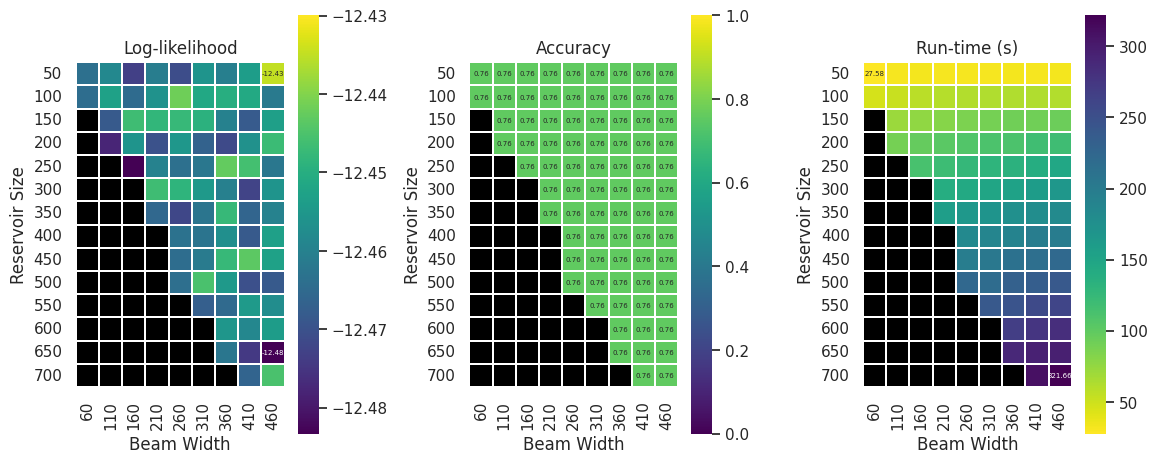

In [368]:
height=5
ratio = results['reservoirsize'].nunique() / results['beamwidth'].nunique()
spacing = 1
fig, ax = plt.subplots(1, 3, figsize=((height*3)/ratio+ spacing,height),gridspec_kw={'width_ratios': [1,1,1]})

cmap = sns.color_palette("viridis", as_cmap=True)
cmap.set_bad(color="black")

l = create_heatmap(lik_avgs, ax[0], lik_avgs.min().min(), lik_avgs.max().max()+ (lik_avgs.max().max()-lik_avgs.min().min()) * 0.1, cmap)
a = create_heatmap(acc_avgs, ax[1], 0, 1, cmap)
r = create_heatmap(run_avgs, ax[2], run_avgs.min().min(), run_avgs.max().max(), cmap.reversed())

ax[0].set_title('Log-likelihood')
ax[1].set_title('Accuracy')
ax[2].set_title('Run-time (s)')

for a in ax:
    a.set_xlabel('Beam Width')
    a.set_ylabel('Reservoir Size')


plt.tight_layout()
plt.savefig('plots/stochbeamsearchgridsearch-{}.png'.format(exp_id), dpi=180)

# Heuristic Search vs baseline

### Choose specific experiement
202304-1700-0801 is the first experiment ran.
Includes 795 total runs. 
With Beam width 1-20 and reservoirs 200-4000 with gaps of 200.
Timeout was 400s, and only 72 runs completed within the time.

Next run will increase the timeout to 1000s, and narrow in the grid search region.

In [68]:

(results, labels) = get_latest_experiment("allexpssmaller")

Getting runs of allexpssmaller
Parsed 630 runs succesfully, consisting of 2 unique experiments with 126 failed runs
Viewing latest result: 2023-04-25 20:04:47


 Extract parameters from algorithm name

We find that the run time increase heavily with both resovoir size and beam width. Close analysis finds that its a result of slices become very large, due to unspreads combining notes. We limit the evaluator to only applow unspreads produces slices up to size $\gamma$. For brevity, we choose a fixed reservoir size, 700.

### Choose specific experiement


In [69]:
results.algorithm.unique()

array(['DualStochasticBeamSearch_5_5', 'DualStochasticBeamSearch_5_40',
       'RandomSample', 'DualStochasticBeamSearch_1_1',
       'RandomWalkPerSegment', 'DualStochasticBeamSearch_12_300',
       'DualStochasticBeamSearch_3_100', 'DualStochasticBeamSearch_12_50',
       'RandomWalk', 'DualStochasticBeamSearch_3_30', 'RandomReduction',
       'DualStochasticBeamSearch_2_2', 'DualStochasticBeamSearch_3_10'],
      dtype=object)

In [70]:
results.loc[results.algorithm == "RandomWalk"]

accuracy  \
id                  corpus             piece                     
2023-04-25 20:04:47 ABC                n09op59-3_04        NaN   
                                       n09op59-3_04        NaN   
                                       n09op59-3_01   0.451866   
                                       n09op59-3_01   0.459725   
                    grieg_lyric_pieces op57n01             NaN   
                                       op57n01             NaN   
                    chopin_mazurkas    BI77-2op17-2        NaN   
                                       BI77-2op17-2        NaN   
                                       BI60-2op06-2        NaN   
                                       BI60-2op06-2        NaN   
                                       BI162-1op63-1  0.437870   
                                       BI162-1op63-1  0.455621   
                                       BI115-2op33-2       NaN   
                                       BI115-2op33-2       NaN   

                                                                                            chordLabels  \
id                  corpus             piece                                                              
2023-04-25 20:04:47 ABC                n09op59-3_04                                                None   
                                       n09op59-3_04                                                None   
                                       n09op59-3_01   [F♯o7, FMm7, Am, DMm7, DMm7, Bm, GM, DMm7, D%7...   
                                       n09op59-3_01   [F♯o7, FMm7, Am, DMm7, DMm7, Bm, GM, DMm7, D%7...   
                    grieg_lyric_pieces op57n01                                                     None   
                                       op57n01                                                     None   
                    chopin_mazurkas    BI77-2op17-2                                                None   
                                       BI77-2op17-2                                                None   
                                       BI60-2op06-2                                                None   
                                       BI60-2op06-2                                                None   
                                       BI162-1op63-1  [BM, A♯M, BM, EM, A♯M, BM, F♯Mm7, D♯m, F♯Mm7, ...   
                                       BI162-1op63-1  [BM, A♯M, BM, EM, A♯M, BM, F♯Mm7, D♯m, F♯Mm7, ...   
                                       BI115-2op33-2                                               None   
                                       BI115-2op33-2                                               None   

                                                      likelihood reRuns  \
id                  corpus             piece                              
2023-04-25 20:04:47 ABC                n09op59-3_04          NaN   None   
                                       n09op59-3_04          NaN   None   
                                       n09op59-3_01   -12.984231    NaN   
                                       n09op59-3_01   -12.998839    NaN   
                    grieg_lyric_pieces op57n01               NaN   None   
                                       op57n01               NaN   None   
                    chopin_mazurkas    BI77-2op17-2          NaN   None   
                                       BI77-2op17-2          NaN   None   
                                       BI60-2op06-2          NaN   None   
                                       BI60-2op06-2          NaN   None   
                                       BI162-1op63-1  -13.203436    NaN   
                                       BI162-1op63-1  -13.107695    NaN   
                                       BI115-2op33-2         NaN   None   
                                       BI115-2op33-2         NaN   None   

                                                        runTime  \
id              

In [71]:
results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).count()

accuracy  likelihood  \
corpus                algorithm                                               
ABC                   DualStochasticBeamSearch_12_300         2           2   
                      DualStochasticBeamSearch_12_50          0           0   
                      DualStochasticBeamSearch_1_1            0           0   
                      DualStochasticBeamSearch_3_100          2           2   
                      DualStochasticBeamSearch_3_30           0           0   
                      DualStochasticBeamSearch_5_40           0           0   
                      DualStochasticBeamSearch_5_5            0           0   
                      RandomReduction                         2           2   
                      RandomSample                           12          12   
                      RandomWalk                              2           2   
                      RandomWalkPerSegment                    4           4   
chopin_mazurkas       DualStochasticBeamSearch_12_300         0           0   
                      DualStochasticBeamSearch_12_50          0           0   
                      DualStochasticBeamSearch_1_1            0           0   
                      DualStochasticBeamSearch_2_2            0           0   
                      DualStochasticBeamSearch_3_10           0           0   
                      DualStochasticBeamSearch_3_100          2           2   
                      DualStochasticBeamSearch_3_30           2           2   
                      DualStochasticBeamSearch_5_40           2           2   
                      DualStochasticBeamSearch_5_5            0           0   
                      RandomReduction                         2           2   
                      RandomSample                           16          16   
                      RandomWalk                              2           2   
                      RandomWalkPerSegment                    2           2   
grieg_lyric_pieces    DualStochasticBeamSearch_12_300         2           2   
                      DualStochasticBeamSearch_12_50          2           2   
                      DualStochasticBeamSearch_1_1            0           0   
                      DualStochasticBeamSearch_2_2            0           0   
                      DualStochasticBeamSearch_3_10           0           0   
                      DualStochasticBeamSearch_3_30           0           0   
                      DualStochasticBeamSearch_5_40           0           0   
                      DualStochasticBeamSearch_5_5            0           0   
                      RandomReduction                         2           2   
                      RandomSample                            4           4   
                      RandomWalk                              0           0   
                      RandomWalkPerSegment                    4           4   
schumann_kinderszenen DualStochasticBeamSearch_12_50          0           0   
                      DualStochasticBeamSearch_3_10           2           2   
                      DualStochasticBeamSearch_3_100          2           2   
                      RandomWalkPerSegment                    0           0   
tests                 DualStochasticBeamSearch_2_2            2           2   
                      DualStochasticBeamSearch_5_40           2           2   

                                                       reRuns  runTime  \
corpus                algorithm                                          
ABC                   DualStochasticBeamSearch_12_300       0        2   
                      DualStochasticBeamSearch_12_50        0        0   
                      DualStochasticBeamSearch_1_1          0        0   
                      DualStochasticBeamSearch_3_100        0        2   
                      DualStochasticBeamSearch_3_30         0        0   
                      DualStochasticBeamSearch_5_40         

In [72]:
#results = results.drop(["id"],axis=1)

In [73]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["algorithm"]).agg([np.mean, np.std])

In [74]:
agm = results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm","piece"]).agg([np.mean, np.std])

/tmp/ipykernel_39/3494776189.py:1: FutureWarning: ['experiment'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  agm = results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm","piece"]).agg([np.mean, np.std])


In [75]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).error

In [76]:
agm2 = agm.groupby(["corpus","algorithm"]).agg(np.mean)

In [77]:
errs = agm.reset_index()["accuracy"]["std"].fillna(0)

In [78]:
a = results.drop(["chordLabels", "slices"], axis=1)

In [79]:
std_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.std)

In [80]:
acc_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

In [81]:
lik_pivot = pd.pivot_table(a, 
                          values="likelihood", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

In [82]:
acc_pivot

algorithm,DualStochasticBeamSearch_12_300,DualStochasticBeamSearch_12_50,DualStochasticBeamSearch_2_2,DualStochasticBeamSearch_3_10,DualStochasticBeamSearch_3_100,DualStochasticBeamSearch_3_30,DualStochasticBeamSearch_5_40,RandomReduction,RandomSample,RandomWalk,RandomWalkPerSegment
corpus,,,,,,,,,,,
ABC,0.455882,NaN,NaN,NaN,0.573034,NaN,NaN,0.465732,0.012806,0.455796,0.326069
chopin_mazurkas,NaN,NaN,NaN,NaN,0.439103,0.763158,0.630435,0.413462,0.015296,0.446746,0.446746
grieg_lyric_pieces,0.300000,0.395349,NaN,NaN,NaN,NaN,NaN,0.380000,0.011905,NaN,0.344828
schumann_kinderszenen,NaN,NaN,NaN,0.40566,0.261364,NaN,NaN,NaN,NaN,NaN,NaN
tests,NaN,NaN,0.136364,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN


In [83]:
lik_pivot

algorithm,DualStochasticBeamSearch_12_300,DualStochasticBeamSearch_12_50,DualStochasticBeamSearch_2_2,DualStochasticBeamSearch_3_10,DualStochasticBeamSearch_3_100,DualStochasticBeamSearch_3_30,DualStochasticBeamSearch_5_40,RandomReduction,RandomSample,RandomWalk,RandomWalkPerSegment
corpus,,,,,,,,,,,
ABC,-12.517404,NaN,NaN,NaN,-12.672152,NaN,NaN,-14.841916,-15.397308,-12.991535,-12.805580
chopin_mazurkas,NaN,NaN,NaN,NaN,-13.826220,-12.510272,-12.096775,-14.364254,-15.347753,-13.155565,-13.193660
grieg_lyric_pieces,-12.703494,-12.853605,NaN,NaN,NaN,NaN,NaN,-14.533144,-15.696718,NaN,-13.125477
schumann_kinderszenen,NaN,NaN,NaN,-13.2326,-12.275463,NaN,NaN,NaN,NaN,NaN,NaN
tests,NaN,NaN,-14.21107,NaN,NaN,NaN,-12.686853,NaN,NaN,NaN,NaN


## Plot Accuracy Chart

In [84]:
ratio = 1
height = 5

In [85]:
lik_pivot.max().max()

-12.096774557551374

In [86]:
lik_pivot


algorithm,DualStochasticBeamSearch_12_300,DualStochasticBeamSearch_12_50,DualStochasticBeamSearch_2_2,DualStochasticBeamSearch_3_10,DualStochasticBeamSearch_3_100,DualStochasticBeamSearch_3_30,DualStochasticBeamSearch_5_40,RandomReduction,RandomSample,RandomWalk,RandomWalkPerSegment
corpus,,,,,,,,,,,
ABC,-12.517404,NaN,NaN,NaN,-12.672152,NaN,NaN,-14.841916,-15.397308,-12.991535,-12.805580
chopin_mazurkas,NaN,NaN,NaN,NaN,-13.826220,-12.510272,-12.096775,-14.364254,-15.347753,-13.155565,-13.193660
grieg_lyric_pieces,-12.703494,-12.853605,NaN,NaN,NaN,NaN,NaN,-14.533144,-15.696718,NaN,-13.125477
schumann_kinderszenen,NaN,NaN,NaN,-13.2326,-12.275463,NaN,NaN,NaN,NaN,NaN,NaN
tests,NaN,NaN,-14.21107,NaN,NaN,NaN,-12.686853,NaN,NaN,NaN,NaN


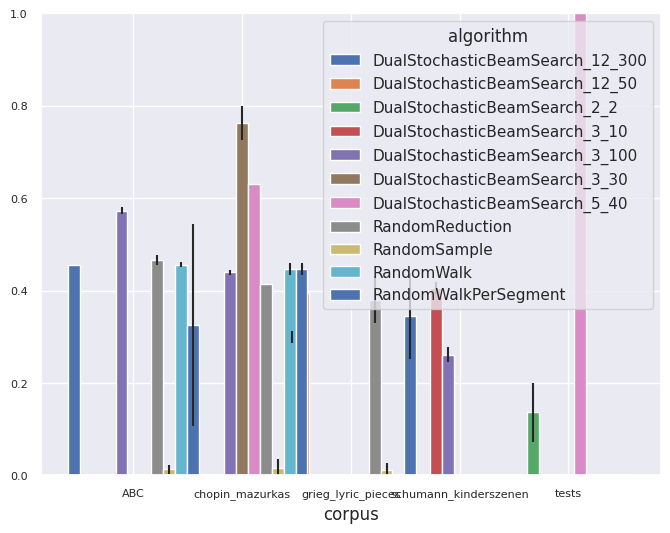

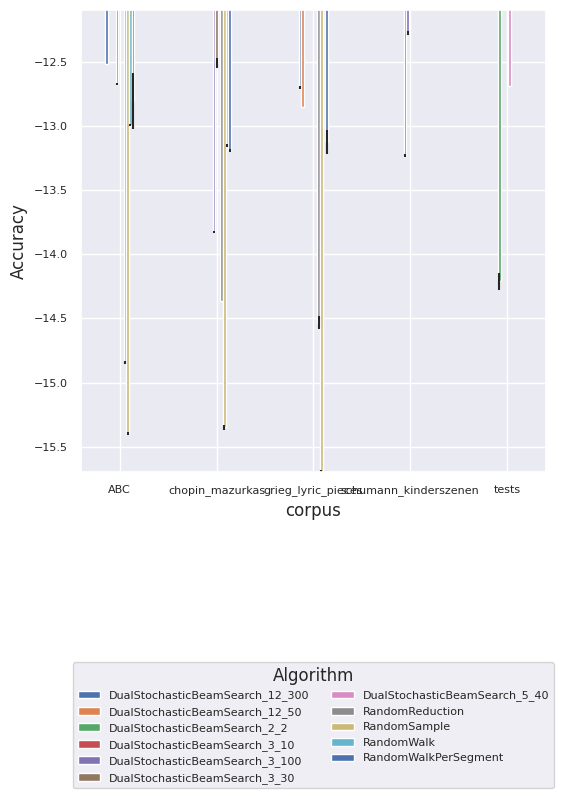

In [87]:
#fig, ax = plt.subplots(1, 2, figsize=((height*2)/ratio+ spacing,height),gridspec_kw={'width_ratios': [1,1]})
#lik_avgs.min().min(), lik_avgs.max().max()+ (lik_avgs.max().max()-lik_avgs.min().min()

sns.set()  # use Seaborn styles
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
r = acc_pivot.plot.bar( yerr=std_pivot,  figsize=(8,6), fontsize=8, rot=0, ylim=(0,1), width=1.2, legend="loc:lower center")
l = lik_pivot.plot.bar(yerr=std_pivot,  figsize=(6,6), fontsize=8, rot=0, ylim=(lik_pivot.min().min(),lik_pivot.max().max()), width=0.3, legend="loc:lower center")

plt.ylabel('Accuracy')
plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})
          

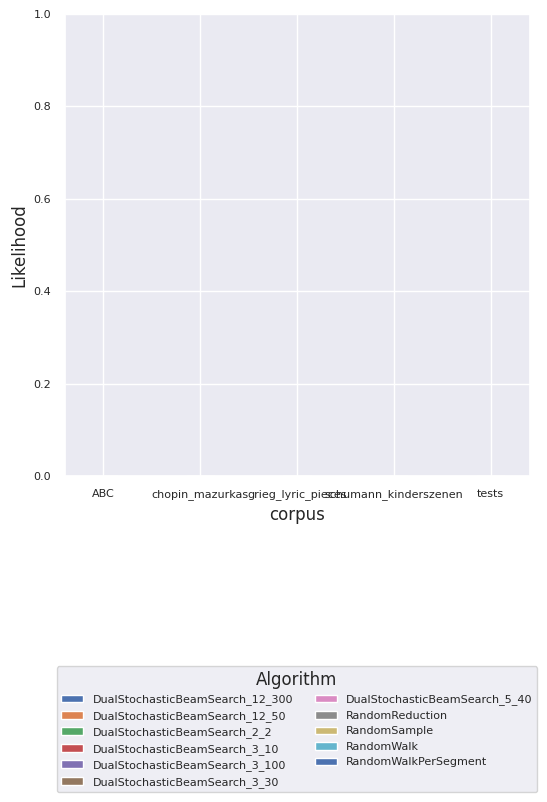

In [88]:
#r = acc_pivot.plot.bar( yerr=std_pivot,  figsize=(6,6), fontsize=8, rot=0, ylim=(0,1), width=0.3, legend="loc:lower center")

l = lik_pivot.plot.bar(figsize=(6,6), fontsize=8, rot=0, ylim=(0,1), width=0.3, legend="loc:lower center")

plt.ylabel('Likelihood')
plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})

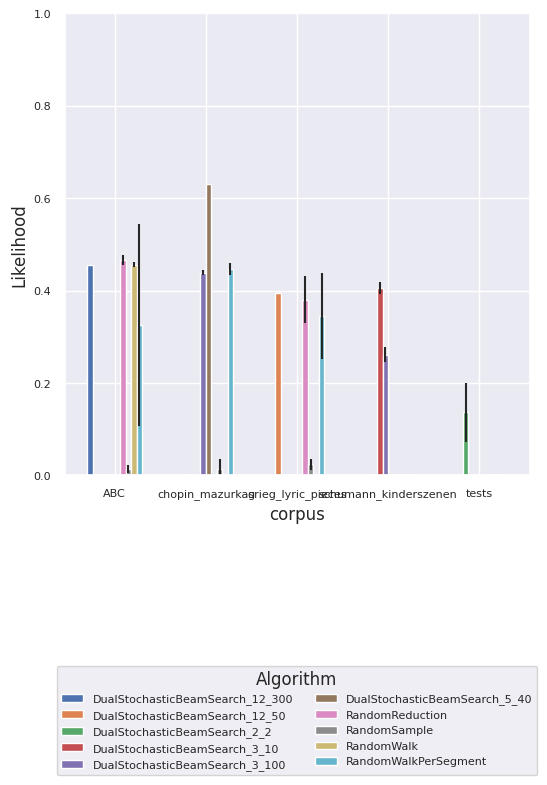

In [636]:
sns.set()  # use Seaborn styles
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,6), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")

plt.ylabel('Likelihood')
plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})

# Heuristic Search vs baseline with smaller beammm

### Choose specific experiement
202304-1700-0801 is the first experiment ran.
Includes 795 total runs. 
With Beam width 1-20 and reservoirs 200-4000 with gaps of 200.
Timeout was 400s, and only 72 runs completed within the time.

Next run will increase the timeout to 1000s, and narrow in the grid search region.

In [567]:

(results, labels) = get_latest_experiment("allexpssmaller")

Getting runs of allexpssmaller
Parsed 545 runs succesfully, consisting of 2 unique experiments with 110 failed runs
Viewing latest result: 2023-04-25 20:04:47


In [608]:
path = "outputs"
experiments, experiment_types = get_all_experiments(path)

In [612]:
results.index.get_level_values(0).max()

Timestamp('2023-04-25 20:04:47')

In [610]:
experiments

{'20230417222410_dual-stochastic-res-params',
 '20230417222926_dual-stochastic-res-params',
 '20230417230541_dual-stochastic-res-params',
 '20230417232707_dual-stochastic-res-params',
 '20230417232917_dual-stochastic-res-params',
 '20230417234107_dual-stochastic-res-params',
 '20230417234107_dual-stochastic-res-params-checkpoint',
 '20230417234922_dual-stochastic-res-params',
 '20230417235221_dual-stochastic-res-params',
 '20230417235446_dual-stochastic-res-params',
 '20230418000144_dual-stochastic-res-params',
 '20230418000536_dual-stochastic-res-params',
 '20230418000726_dual-stochastic-res-params',
 '20230418001926_dual-stochastic-res-params-grieg128',
 '20230418002216_dual-stochastic-res-params-grieg128',
 '20230418015420_dual-stochastic-res-500-400vs3-1-grieg128',
 '20230418053444_dual-stochastic-res-500-400vs3-1-grieg128',
 '20230418053444_dual-stochastic-res-500-400vs3-1-grieg128-checkpoint',
 '20230418074732_dual-stochastic-res-500-400vs3-1-grieg128',
 '20230418074732_dual-stoc

In [605]:
exp_id= "20230420212353"

In [606]:
(results, groundTruth) = get_experiments(exp_id)


Can't find experiment 20230420212353


 Extract parameters from algorithm name

We find that the run time increase heavily with both resovoir size and beam width. Close analysis finds that its a result of slices become very large, due to unspreads combining notes. We limit the evaluator to only applow unspreads produces slices up to size $\gamma$. For brevity, we choose a fixed reservoir size, 700.

### Choose specific experiement


In [594]:
results.algorithm.unique()

array(['RandomSample', 'RandomWalkPerSegment', 'RandomReduction',
       'DualStochasticBeamSearch_2_2', 'DualStochasticBeamSearch_3_10',
       'RandomWalk', 'DualStochasticBeamSearch_5_40',
       'DualStochasticBeamSearch_3_100'], dtype=object)

In [597]:
results

accuracy  \
id                  corpus             piece                     
2023-04-25 20:04:47 ABC                n13op130_06    0.019324   
                                       n13op130_06    0.022544   
                                       n15op132_04    0.141593   
                                       n15op132_04    0.132743   
                                       n15op132_04    0.000000   
                                       n15op132_04    0.008850   
                                       n05op18-5_02   0.520958   
                                       n05op18-5_02   0.508982   
                                       n10op74_04     0.473520   
                                       n10op74_04     0.457944   
                    tests              short          0.181818   
                                       short          0.090909   
                    grieg_lyric_pieces op68n02        0.419355   
                                       op68n02        0.430108   
                                       op12n02        0.416000   
                                       op12n02        0.344000   
                                       op65n02             NaN   
                                       op65n02             NaN   
                                       op57n01             NaN   
                                       op57n01             NaN   
                    chopin_mazurkas    BI89-1op24-1        NaN   
                                       BI89-1op24-1        NaN   
                                       BI71           0.008197   
                                       BI71           0.008197   
                                       BI16-2         0.021739   
                                       BI16-2         0.000000   
                                       BI16-2         0.630435   
                                       BI16-2         0.630435   
                                       BI105-3op30-3  0.018868   
                                       BI105-3op30-3  0.006289   
                                       BI153-2op56-2  0.442308   
                                       BI153-2op56-2  0.435897   
                                       BI77-3op17-3   0.009524   
                                       BI77-3op17-3   0.009524   
                                       BI145-1op50-1  0.032407   
                                       BI145-1op50-1  0.009259   
                                       BI61-5op07-5   0.078947   
                                       BI61-5op07-5   0.000000   

                                                                                            chordLabels  \
id                  corpus             piece                                                              
2023-04-25 20:04:47 ABC                n13op130_06    [DM, F♯Mm7, C♯o7, GM, Ao7, E♭Mm7, Do7, CM, A♭M...   
                                       n13op130_06    [AM, BM, AM, A♭Mm7, G♭M, DM, GM, F♯o7, BMm7, E...   
                                       n15op132_04    [EM, AM, AM, G♯o, AM, EMm7, AM, AM, AM, AM, DM...   
                                       n15op132_04    [EM, AM, AM, G♯o, AM, EMm7, AM, AM, AM, AM, DM...   
                                       n15op132_04    [B♭M, AMm7, BM, G♭M, CM, D♭M, FM, Cm, E♭M, GMm...   
                                       n15op132_04    [B♭M, FM, DM, F♯Mm7, FMm7, Ao7, GM, A♭Mm7, Eo,...   
                                       n05op18-5_02   [AM, EM, AM, AM, BM, AM, F♯M, BMm7, D♯M, BMm7,...   
                                       n05op18-5_02   [C♯M, EM, AM, AM, C♯M, AM, F♯M, DM, D♯M, BMm7,...   
                                       n10op74_04     [E♭M, E♭M, A♭M, Fm, Gmm7, B♭M, B♭M, B♭M, Gm, E...   
                                       n10op74_04     [E♭M, E♭M, A♭M, Fm, B♭M, B♭M, B♭M, B♭M, E♭M, E...   
                    tests              short             [FM, FM, CM, FM, DM, CMm7, FM, Dm, Gm, FM, FM]   
                      

In [595]:
results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).count()

accuracy  likelihood  \
corpus             algorithm                                              
ABC                RandomReduction                        2           2   
                   RandomSample                           4           4   
                   RandomWalkPerSegment                   4           4   
chopin_mazurkas    DualStochasticBeamSearch_3_100         2           2   
                   DualStochasticBeamSearch_5_40          2           2   
                   RandomSample                          12          12   
                   RandomWalkPerSegment                   0           0   
grieg_lyric_pieces DualStochasticBeamSearch_3_10          0           0   
                   RandomReduction                        2           2   
                   RandomWalk                             0           0   
                   RandomWalkPerSegment                   2           2   
tests              DualStochasticBeamSearch_2_2           2           2   

                                                   reRuns  runTime  reruns  \
corpus             algorithm                                                 
ABC                RandomReduction                      0        2       2   
                   RandomSample                         0        4       4   
                   RandomWalkPerSegment                 0        4       4   
chopin_mazurkas    DualStochasticBeamSearch_3_100       0        2       2   
                   DualStochasticBeamSearch_5_40        0        2       2   
                   RandomSample                         0       12      12   
                   RandomWalkPerSegment                 0        0       0   
grieg_lyric_pieces DualStochasticBeamSearch_3_10        0        0       0   
                   RandomReduction                      0        2       2   
                   RandomWalk                           0        0       0   
                   RandomWalkPerSegment                 0        2       2   
tests              DualStochasticBeamSearch_2_2         0        2       2   

                                                   experiment  
corpus             algorithm                                   
ABC                RandomReduction                          2  
                   RandomSample                             4  
                   RandomWalkPerSegment                     4  
chopin_mazurkas    DualStochasticBeamSearch_3_100           2  
                   DualStochasticBeamSearch_5_40            2  
                   RandomSample                            12  
                   RandomWalkPerSegment                     2  
grieg_lyric_pieces DualStochasticBeamSearch_3_10            2  
                   RandomReduction                          2  
                   RandomWalk                               2  
                   RandomWalkPerSegment                     2  
tests              DualStochasticBeamSearch_2_2             2

In [570]:
#results = results.drop(["id"],axis=1)

In [571]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["algorithm"]).agg([np.mean, np.std])

In [572]:
agm = results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm","piece"]).agg([np.mean, np.std])

/tmp/ipykernel_135821/3494776189.py:1: FutureWarning: ['experiment'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  agm = results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm","piece"]).agg([np.mean, np.std])


In [573]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).error

In [574]:
agm2 = agm.groupby(["corpus","algorithm"]).agg(np.mean)

In [575]:
errs = agm.reset_index()["accuracy"]["std"].fillna(0)

In [576]:
a = results.drop(["chordLabels", "slices"], axis=1)

In [577]:
std_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.std)

In [578]:
acc_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

In [579]:
lik_pivot = pd.pivot_table(a, 
                          values="likelihood", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

In [596]:
acc_pivot

algorithm,DualStochasticBeamSearch_2_2,DualStochasticBeamSearch_3_100,DualStochasticBeamSearch_5_40,RandomReduction,RandomSample,RandomWalkPerSegment
corpus,,,,,,
ABC,NaN,NaN,NaN,0.465732,0.012679,0.326069
chopin_mazurkas,NaN,0.439103,0.630435,NaN,0.016913,NaN
grieg_lyric_pieces,NaN,NaN,NaN,0.380000,NaN,0.424731
tests,0.136364,NaN,NaN,NaN,NaN,NaN


In [581]:
lik_pivot

algorithm,DualStochasticBeamSearch_2_2,DualStochasticBeamSearch_3_100,DualStochasticBeamSearch_5_40,RandomReduction,RandomSample,RandomWalkPerSegment
corpus,,,,,,
ABC,NaN,NaN,NaN,-14.841916,-15.129499,-12.805580
chopin_mazurkas,NaN,-13.82622,-12.096775,NaN,-15.373929,NaN
grieg_lyric_pieces,NaN,NaN,NaN,-14.533144,NaN,-12.668857
tests,-14.21107,NaN,NaN,NaN,NaN,NaN


## Plot Accuracy Chart

In [582]:
ratio = 1
height = 5

In [583]:
lik_pivot.max().max()

-12.096774557551374

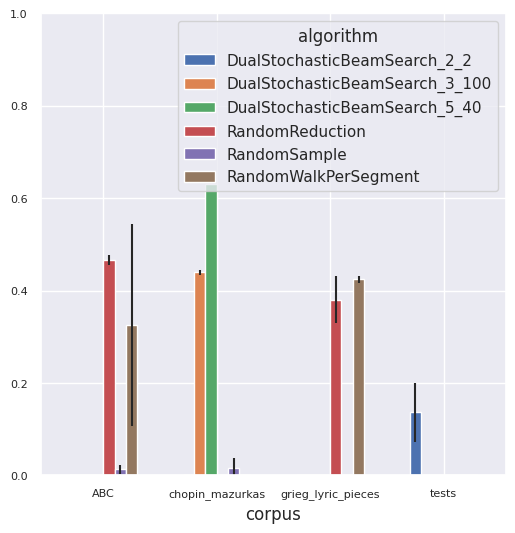

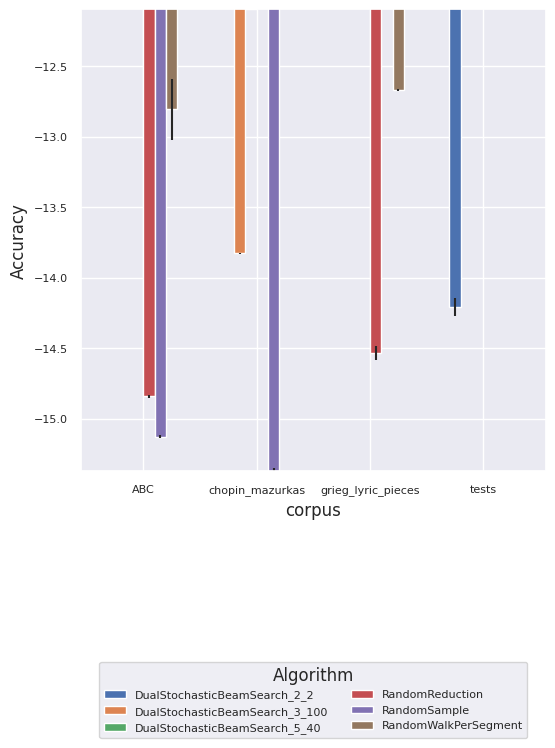

In [584]:
#fig, ax = plt.subplots(1, 2, figsize=((height*2)/ratio+ spacing,height),gridspec_kw={'width_ratios': [1,1]})
#lik_avgs.min().min(), lik_avgs.max().max()+ (lik_avgs.max().max()-lik_avgs.min().min()

sns.set()  # use Seaborn styles
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
r = acc_pivot.plot.bar( yerr=std_pivot,  figsize=(6,6), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
l = lik_pivot.plot.bar(yerr=std_pivot,  figsize=(6,6), fontsize=8, rot=0, ylim=(lik_pivot.min().min(),lik_pivot.max().max()), width=0.6, legend="loc:lower center")

plt.ylabel('Accuracy')
plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})
          

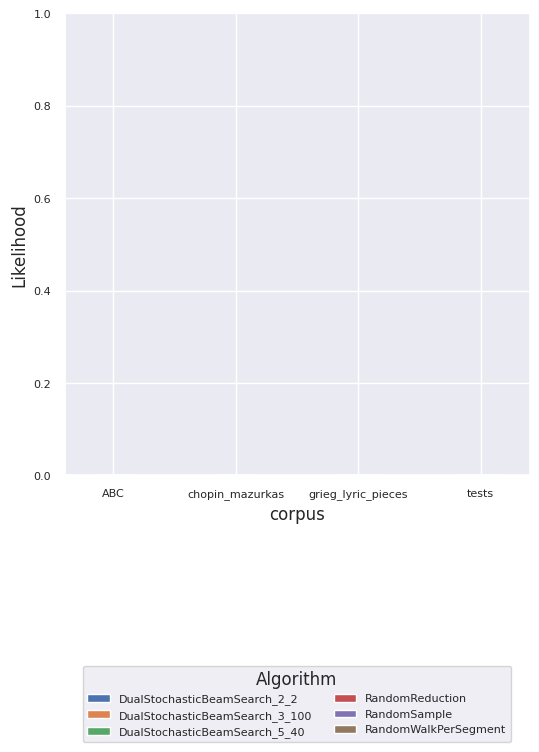

In [585]:
#r = acc_pivot.plot.bar( yerr=std_pivot,  figsize=(6,6), fontsize=8, rot=0, ylim=(0,1), width=0.3, legend="loc:lower center")

l = lik_pivot.plot.bar(figsize=(6,6), fontsize=8, rot=0, ylim=(0,1), width=0.3, legend="loc:lower center")

plt.ylabel('Likelihood')
plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})

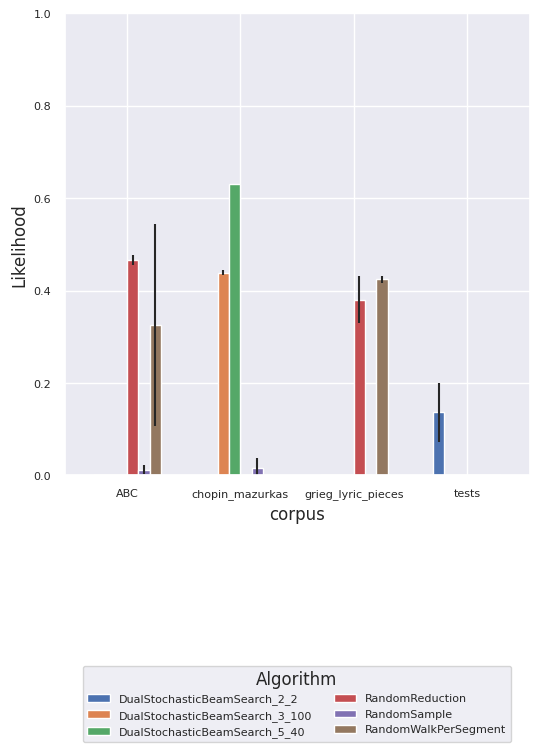

In [586]:
sns.set()  # use Seaborn styles
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,6), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")

plt.ylabel('Likelihood')
plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})

In [587]:
exp_id = "202304-1715-2135"

In [588]:
exp_df = results.xs(exp_id,level=1)

KeyError: '202304-1715-2135'

In [ ]:
stochastic_params_lim_df = exp_df.xs("stochastic-limited-fixed-res",level=0)

In [ ]:
stochastic_params_lim_df

 Extract parameters from algorithm name

In [ ]:
stochastic_params_lim_df['beamwidth'] = stochastic_params_lim_df["algorithm"].apply(lambda s: int(s.split("_")[1]))
stochastic_params_lim_df['limit'] = stochastic_params_lim_df["algorithm"].apply(lambda s: int(s.split("_")[3]))

## Accuracy, loglikelihood and runtime

In [ ]:
def get_avgs(df, value):
    g = df.dropna(subset=value).groupby(['beamwidth','limit'])
    df_means = g[value].mean()
    return df_means.loc[:,:].reset_index().pivot(index='limit', columns='beamwidth', values=value)

In [ ]:
acc_avgs = get_avgs(stochastic_params_lim_df, 'accuracy')
lik_avgs = get_avgs(stochastic_params_lim_df, 'likelihood')
run_avgs = get_avgs(stochastic_params_lim_df, 'runTime')

## Plot hyperparemter results

In [ ]:
def create_heatmap(xs, ax, vmin, vmax,cmap):
    lbls = xs.applymap(lambda v: "{:.2f}".format(v) if v in [np.nanmax(xs.values),np.nanmin(xs.values)]else '')
    return sns.heatmap(xs,
            square=True,
            ax=ax,
            cmap=cmap,
            fmt='',
            annot=lbls, # Label the maximum value
            annot_kws={'fontsize':5},
            mask=xs.isna(),
            vmax=vmax,
            vmin=vmin,
            linewidth=0.01)

In [ ]:
height=5
ratio = stochastic_params_lim_df['limit'].nunique() / stochastic_params_lim_df['beamwidth'].nunique()
spacing = 1
fig, ax = plt.subplots(1, 3, figsize=((height*3)/ratio+ spacing,height),gridspec_kw={'width_ratios': [1,1,1]})

cmap = sns.color_palette("viridis", as_cmap=True)
cmap.set_bad(color="black")

l = create_heatmap(lik_avgs, ax[0], lik_avgs.min().min(), lik_avgs.max().max()+ (lik_avgs.max().max()-lik_avgs.min().min()) * 0.1, cmap)
a = create_heatmap(acc_avgs, ax[1], 0, 1, cmap)
r = create_heatmap(run_avgs, ax[2], run_avgs.min().min(), run_avgs.max().max(), cmap.reversed())

ax[0].set_title('Log-likelihood')
ax[1].set_title('Accuracy')
ax[2].set_title('Run-time (s)')

for a in ax:
    a.set_xlabel('Beam Width')
    a.set_ylabel('Slice Limit')


plt.tight_layout()
plt.savefig('plots/stochbeamlimgridsearch-{}.png'.format(exp_id), dpi=180)

# Analysis on latest experiment

In [ ]:
results = results.drop(["id"],axis=1)

In [ ]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["algorithm"]).agg([np.mean, np.std])

In [ ]:
agm = results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).agg([np.mean, np.std])

In [ ]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).errors()

In [ ]:
agm = results.drop(["chordLabels", "slices","runTime","likelihood"], axis=1).groupby(["corpus", "algorithm"]).agg([np.std])

In [ ]:
errs = agm.reset_index()["accuracy"]["std"].fillna(0)

In [ ]:
a = results.drop(["chordLabels", "slices"], axis=1)

In [ ]:
std_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.std)

In [ ]:
acc_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

## Plot Accuracy Chart

In [ ]:
sns.set()  # use Seaborn styles
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
#plt.ylabel('Accuracy')
#plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})
          

# Close Error Analysis

Attributes: chord type, root note, etc

#### Zoom in on ABC: n02op18-2_03

In [ ]:
groundTruth.loc['ABC','n02op18-2_03']

In [ ]:
results

In [ ]:
ex = results.loc['schumann_kinderszenen','n04']

In [ ]:
ex[["algorithm", "accuracy", "likelihood", "runTime"]]